<a href="https://colab.research.google.com/github/mayatahir/ECGR-5105/blob/master/Homework_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6
## Prediction and Classification with Fully Connected Neural Networks


In [1]:
#Importing Relevant Libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

# Data paths
csv_file = '/content/gdrive/My Drive/data/Housing.csv'
model_data = '/content/gdrive/My Drive/data//model_data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Read housing dataset
df = pd.read_csv(csv_file)

# Print dataset summary
print(df)
df.shape

        price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0    13300000  7420         4          2        3      yes        no       no   
1    12250000  8960         4          4        4      yes        no       no   
2    12250000  9960         3          2        2      yes        no      yes   
3    12215000  7500         4          2        2      yes        no      yes   
4    11410000  7420         4          1        2      yes       yes      yes   
..        ...   ...       ...        ...      ...      ...       ...      ...   
540   1820000  3000         2          1        1      yes        no      yes   
541   1767150  2400         3          1        1       no        no       no   
542   1750000  3620         2          1        1      yes        no       no   
543   1750000  2910         3          1        1       no        no       no   
544   1750000  3850         3          1        2      yes        no       no   

    hotwaterheating aircond

(545, 13)

In [4]:
# List of variables to map
binary_features =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
ternary_features = ['furnishingstatus']

# Defining the map functions
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

def ternary_map(x):
    return x.map({'furnished':2, 'semi-furnished':1, 'unfurnished':0})

# Applying the function to the housing list
df[binary_features] = df[binary_features].apply(binary_map)
df[ternary_features] = df[ternary_features].apply(ternary_map)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2


In [5]:
# Normalize data
scaler = StandardScaler()
df_norm = df.copy() # copy df to not modify orignal data frame
df_norm[:] = scaler.fit_transform(df_norm)
df_norm.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,4.566365,1.046726,1.403419,1.421812,1.378217,0.405623,-0.465315,-0.734539,-0.219265,1.472618,1.517692,1.804941,1.406286
1,4.004484,1.757010,1.403419,5.405809,2.532024,0.405623,-0.465315,-0.734539,-0.219265,1.472618,2.679409,-0.554035,1.406286
2,4.004484,2.218232,0.047278,1.421812,0.224410,0.405623,-0.465315,1.361397,-0.219265,-0.679063,1.517692,1.804941,0.091662
3,3.985755,1.083624,1.403419,1.421812,0.224410,0.405623,-0.465315,1.361397,-0.219265,1.472618,2.679409,1.804941,1.406286
4,3.554979,1.046726,1.403419,-0.570187,0.224410,0.405623,2.149083,1.361397,-0.219265,1.472618,1.517692,-0.554035,1.406286


In [6]:
# Create list of features and output
features = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',\
     'guestroom', 'basement', 'hotwaterheating', 'airconditioning',\
        'parking', 'prefarea', 'furnishingstatus'
        ]
output = ['price']

In [7]:
# Useful method to reset all weights in a model
def reset_all_weights(model: nn.Module) -> None:
    """
    refs:
        - https://discuss.pytorch.org/t/how-to-re-set-alll-parameters-in-a-network/20819/6
        - https://stackoverflow.com/questions/63627997/reset-parameters-of-a-neural-network-in-pytorch
        - https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    """

    @torch.no_grad()
    def weight_reset(m: nn.Module):
        # - check if the current module has reset_parameters & if it's callabed called it on m
        reset_parameters = getattr(m, "reset_parameters", None)
        if callable(reset_parameters):
            m.reset_parameters()

    # Applies fn recursively to every submodule see: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    model.apply(fn=weight_reset)


In [8]:
# Method to define model optimizers
def get_optimizers(model):
    optimizers = {
        "SGD": optim.SGD(model.parameters(), lr=1e-3),
        "Adam": optim.Adam(model.parameters(), lr=1e-3)
    }
    return optimizers

In [9]:
# Method to plot training and validations losses
def plot_loss(train_loss, val_loss=[], title='', epoch_step=500):
    num_epochs = epoch_step * len(train_loss)
    epochs = list(range(0, num_epochs, epoch_step))
    plt.figure(figsize = (10, 6)) # New figure
    plt.grid(True)
    plt.plot(epochs, train_loss, color='blue', label = "Training Loss")
    if val_loss:
        plt.plot(epochs, val_loss, color='red', label = "Validation Loss")
    plt.legend()
    if not title:
        plt.title('Model Loss')
    else:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Number of Epochs')
    plt.show()

## Problem 1 (40 pts):

a. Develop a Fully Connected Neural Network with only one hidden layer (size of 32) to predict the housing value for the housing dataset. Make sure to include all input features. Compare your training loss value and validation results against the linear regression you implemented in Homework 5. Can you compare your model complexity (number of trainable parameters) against linear regression? Note: Perform 20%, and 80% split for training and validation.



b. We will increase the network complexity by adding two additional hidden layers, the hidden layers overall. My suggestions for the size of layers are: 32, 64, 16, respectively. Please redesign the network and compare your training loss value and validation results against the linear regression you implemented in Homework 5 and Problem 1.a. Can you compare your model complexity? Note: Use the same 20%, and 80% split for training and validation.

In [10]:
# Defining training loop
def training_loop(n_epochs, optimizer, model, loss_fn, X, Y):
    loss_train_list = []
    loss_val_list = []
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=9999)
    x_train = torch.tensor(x_train, dtype=torch.float)
    x_val = torch.tensor(x_val, dtype=torch.float)
    y_train = torch.tensor(y_train, dtype=torch.float)
    y_val = torch.tensor(y_val, dtype=torch.float)
    for epoch in range(1, n_epochs + 1):
        # trian model
        y_pred = model(x_train)
        loss_train = loss_fn(y_pred, y_train)
        # validate model
        with torch.no_grad():
            y_pred = model(x_val)
            loss_val = loss_fn(y_pred, y_val)
        # run optimizer
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # Save losses
        if (epoch == 1) or (epoch % 500 == 0):
            loss_train_list.append(loss_train.item())
            loss_val_list.append(loss_val.item())
            print(f"Epoch {epoch:04d}, Training loss {loss_train.item():.4f}, "
                f"Validation loss {loss_val.item():.4f}")
    return loss_train_list, loss_val_list


### 1a. FC NN with 1 Hidden Layer

In [11]:
# Build model
model_1hl = nn.Sequential(
        nn.Linear(12, 32),
        nn.Tanh(),
        nn.Linear(32, 1)
)
optimizers = get_optimizers(model_1hl)

# Inspect model parameters
for name, param in model_1hl.named_parameters():
    print(name, param.shape)

0.weight torch.Size([32, 12])
0.bias torch.Size([32])
2.weight torch.Size([1, 32])
2.bias torch.Size([1])


Training with SGD Optimizer
Epoch 0001, Training loss 1.2328, Validation loss 0.8896
Epoch 0500, Training loss 0.4084, Validation loss 0.3658
Epoch 1000, Training loss 0.3566, Validation loss 0.3709
Epoch 1500, Training loss 0.3445, Validation loss 0.3680
Epoch 2000, Training loss 0.3388, Validation loss 0.3642
Epoch 2500, Training loss 0.3353, Validation loss 0.3617
Epoch 3000, Training loss 0.3328, Validation loss 0.3602
Epoch 3500, Training loss 0.3307, Validation loss 0.3592
Epoch 4000, Training loss 0.3288, Validation loss 0.3586
Epoch 4500, Training loss 0.3270, Validation loss 0.3580
Epoch 5000, Training loss 0.3253, Validation loss 0.3575


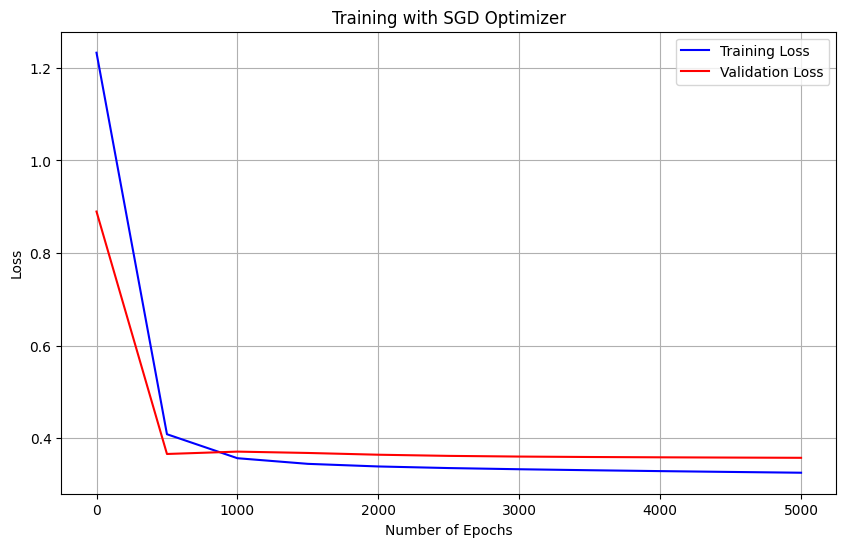

Training with Adam Optimizer
Epoch 0001, Training loss 0.9451, Validation loss 0.6234
Epoch 0500, Training loss 0.2468, Validation loss 0.3450
Epoch 1000, Training loss 0.1251, Validation loss 0.3563
Epoch 1500, Training loss 0.0750, Validation loss 0.3988
Epoch 2000, Training loss 0.0480, Validation loss 0.4327
Epoch 2500, Training loss 0.0335, Validation loss 0.4944
Epoch 3000, Training loss 0.0254, Validation loss 0.5813
Epoch 3500, Training loss 0.0211, Validation loss 0.6709
Epoch 4000, Training loss 0.0188, Validation loss 0.7287
Epoch 4500, Training loss 0.0170, Validation loss 0.8007
Epoch 5000, Training loss 0.0156, Validation loss 0.9084


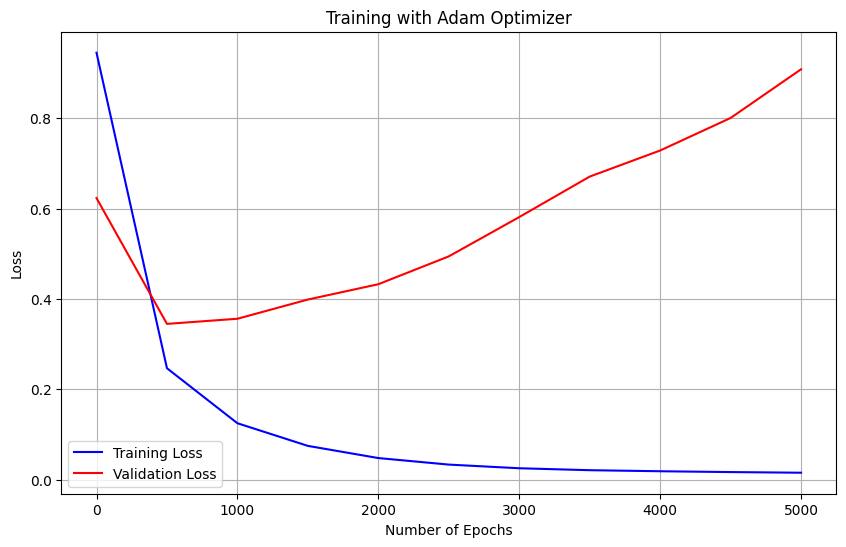

In [12]:
# Run training loop
for name, optimizer in optimizers.items():
    label = "Training with " + name + " Optimizer"
    print(label)
    reset_all_weights(model_1hl)
    train_loss, val_loss = training_loop(
        n_epochs=5000, optimizer=optimizer, model=model_1hl,
        loss_fn = nn.MSELoss(),
        X = df_norm[features].to_numpy(),
        Y = df_norm[output].to_numpy()
    )
    plot_loss(train_loss, val_loss, label)

### 1b. FC NN with 3 Hidden Layers

In [13]:
# Build model
model_3hl = nn.Sequential(
        nn.Linear(12, 32),
        nn.Tanh(),
        nn.Linear(32, 64),
        nn.Tanh(),
        nn.Linear(64, 16),
        nn.Tanh(),
        nn.Linear(16, 1)
)
optimizers = get_optimizers(model_3hl)

# Inspect model parameters
for name, param in model_3hl.named_parameters():
    print(name, param.shape)

0.weight torch.Size([32, 12])
0.bias torch.Size([32])
2.weight torch.Size([64, 32])
2.bias torch.Size([64])
4.weight torch.Size([16, 64])
4.bias torch.Size([16])
6.weight torch.Size([1, 16])
6.bias torch.Size([1])


Training with SGD Optimizer
Epoch 0001, Training loss 1.0943, Validation loss 0.7673
Epoch 0500, Training loss 0.6133, Validation loss 0.4437
Epoch 1000, Training loss 0.4386, Validation loss 0.3591
Epoch 1500, Training loss 0.3939, Validation loss 0.3496
Epoch 2000, Training loss 0.3719, Validation loss 0.3468
Epoch 2500, Training loss 0.3581, Validation loss 0.3484
Epoch 3000, Training loss 0.3487, Validation loss 0.3520
Epoch 3500, Training loss 0.3418, Validation loss 0.3562
Epoch 4000, Training loss 0.3365, Validation loss 0.3601
Epoch 4500, Training loss 0.3322, Validation loss 0.3632
Epoch 5000, Training loss 0.3284, Validation loss 0.3656


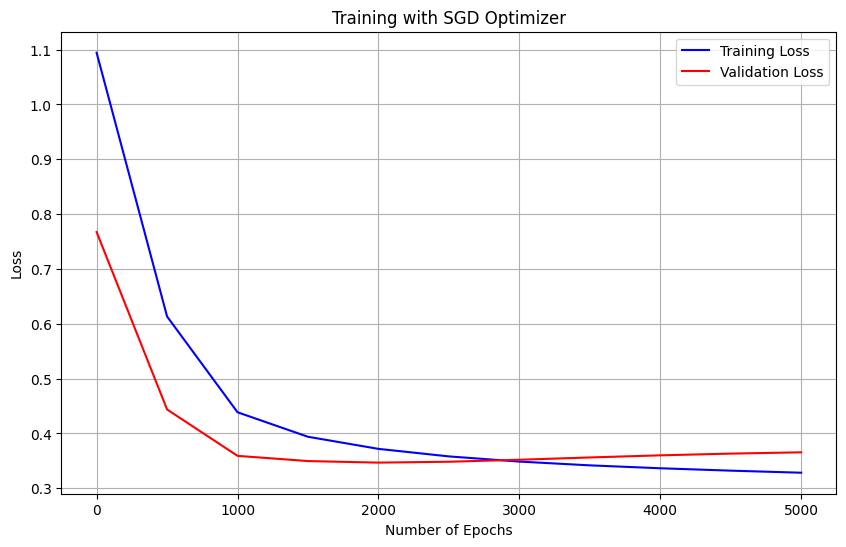

Training with Adam Optimizer
Epoch 0001, Training loss 1.2016, Validation loss 1.0493
Epoch 0500, Training loss 0.0815, Validation loss 0.6428
Epoch 1000, Training loss 0.0281, Validation loss 1.0542
Epoch 1500, Training loss 0.0159, Validation loss 1.2323
Epoch 2000, Training loss 0.0129, Validation loss 1.3398
Epoch 2500, Training loss 0.0114, Validation loss 1.4366
Epoch 3000, Training loss 0.0108, Validation loss 1.5442
Epoch 3500, Training loss 0.0125, Validation loss 1.6695
Epoch 4000, Training loss 0.0082, Validation loss 1.7646
Epoch 4500, Training loss 0.0075, Validation loss 1.8681
Epoch 5000, Training loss 0.0071, Validation loss 1.9701


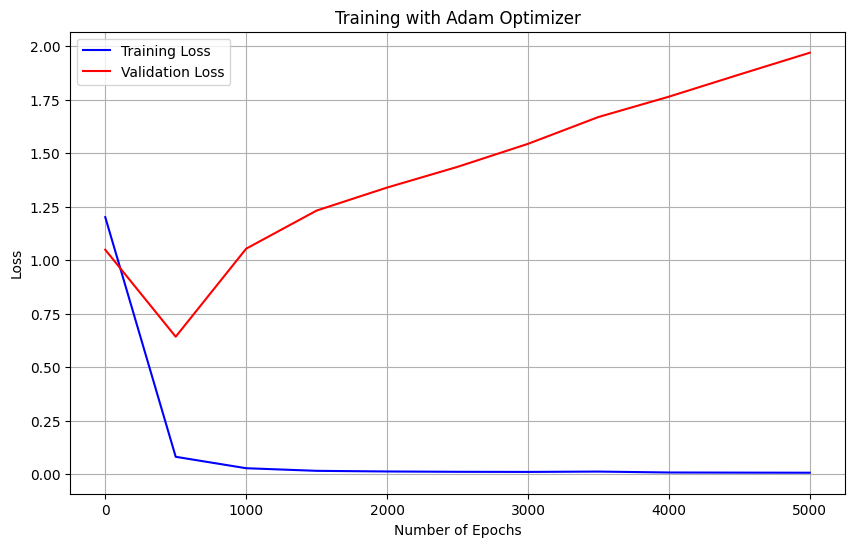

In [14]:
# Run training loop
for name, optimizer in optimizers.items():
    label = "Training with " + name + " Optimizer"
    print(label)
    reset_all_weights(model_3hl)
    train_loss, val_loss = training_loop(
        n_epochs=5000, optimizer=optimizer, model=model_3hl,
        loss_fn = nn.MSELoss(),
        X = df_norm[features].to_numpy(),
        Y = df_norm[output].to_numpy()
    )
    plot_loss(train_loss, val_loss, label)

## Problem 2 (60 pts):

a. Create a fully connected Neural Network for all 10 classes in CIFAR-10 with only one hidden layer with a size of 512. Report your training time, training loss, and evaluation accuracy. Analyze your results in your report. Make sure to submit your code by providing the GitHub URL of your course repository for this course. (25pt)

b. Extend your network with two more additional hidden layers, like the example we did in the lecture (pick the sizes of hidden layers properly). Train your network. Report your training time, loss, and evaluation accuracy after 300 epochs. Analyze your results in your report and compare your model size and accuracy over the baseline implementation in Problem 2.a. Do you see any over-fitting? Can you compare your model complexity against problem 2.a? Make sure to submit your code by providing the GitHub URL of your course repository for this course. (35pt)

In [15]:
device = ''
if torch.cuda.is_available():
    device = 'cuda:0'
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'
device = torch.device(device)
print(device)

cpu


In [16]:
# Read CIFAR-10 dataset
data_path = './cifar10'
batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))]) # mean and std the from slides


cifar10_train = datasets.CIFAR10(root=data_path, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

cifar10_val = datasets.CIFAR10(root=data_path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(cifar10_val, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [17]:
def check_model(model, loader):
    print("Checking model...")
    correct = 0
    total = 0
    accuracy = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in loader:
            imgs, labels = data[0].to(device), data[1].to(device) # send to GPU
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            batch_pred = predicted.cpu().numpy() # retreive from GPU
            batch_true = labels.cpu().numpy() # retreive from GPU
            y_pred.extend(batch_pred.squeeze().tolist())
            y_true.extend(batch_true.squeeze().tolist())
    accuracy = correct / total
    return accuracy, y_pred, y_true

In [18]:
# Define training loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    loss_list = []
    t0 = time.time()
    for epoch in range(1, n_epochs + 1):
        for data in train_loader:
            imgs, labels = data[0].to(device), data[1].to(device) # send to GPU
            # trian model
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            loss = loss_fn(outputs, labels)
            # run optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Save loss of last batch
        loss_list.append(float(loss))
        if (epoch == 1) or (epoch % 10 == 0):
            print(f"Epoch {epoch:04d}, Loss {float(loss):.4f}, ")
    train_time = time.time() - t0
    return loss_list, train_time

### 2a. FC NN CIFAR-10 with 1 Hidden Layer

In [19]:
model_cifar10_1hl = nn.Sequential(
    nn.Linear(3072, 512), # 32 x 32 x 3 = 3072
    nn.Tanh(),
    nn.Linear(512, 10)
)
model_cifar10_1hl.to(device) # send to GPU
optimizers = get_optimizers(model_cifar10_1hl)

# Inspect model parameters
numel_list = [p.numel()
              for p in model_cifar10_1hl.parameters()
              if p.requires_grad == True]
print("Model parameters: " + str(numel_list))
print("Total parameters: " + str(sum(numel_list)))


Model parameters: [1572864, 512, 5120, 10]
Total parameters: 1578506


Loading model trained with SGD optimizer
Checking model...
Checking model...
Training Accuracy: 0.89488,  Validation Accuracy: 0.4945
Training time: 5967.7530398368835 sec
              precision    recall  f1-score   support

           0       0.56      0.56      0.56      1000
           1       0.65      0.59      0.62      1000
           2       0.36      0.35      0.36      1000
           3       0.34      0.30      0.32      1000
           4       0.43      0.44      0.43      1000
           5       0.39      0.39      0.39      1000
           6       0.50      0.57      0.53      1000
           7       0.56      0.52      0.54      1000
           8       0.60      0.68      0.63      1000
           9       0.56      0.54      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



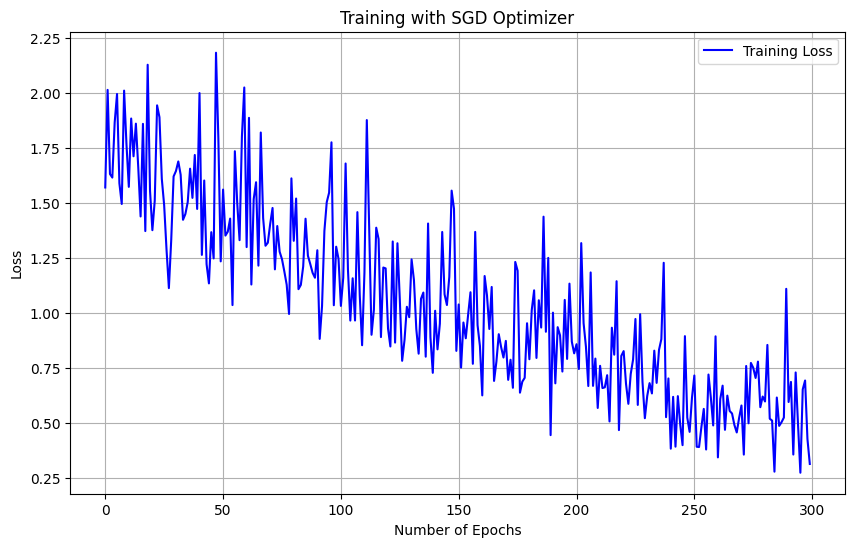

Loading model trained with Adam optimizer
Checking model...
Checking model...
Training Accuracy: 0.8751,  Validation Accuracy: 0.3836
Training time: 6821.945519208908 sec
              precision    recall  f1-score   support

           0       0.44      0.51      0.47      1000
           1       0.49      0.43      0.45      1000
           2       0.25      0.25      0.25      1000
           3       0.24      0.22      0.23      1000
           4       0.32      0.30      0.31      1000
           5       0.28      0.29      0.29      1000
           6       0.43      0.45      0.44      1000
           7       0.41      0.41      0.41      1000
           8       0.52      0.53      0.52      1000
           9       0.46      0.45      0.45      1000

    accuracy                           0.38     10000
   macro avg       0.38      0.38      0.38     10000
weighted avg       0.38      0.38      0.38     10000



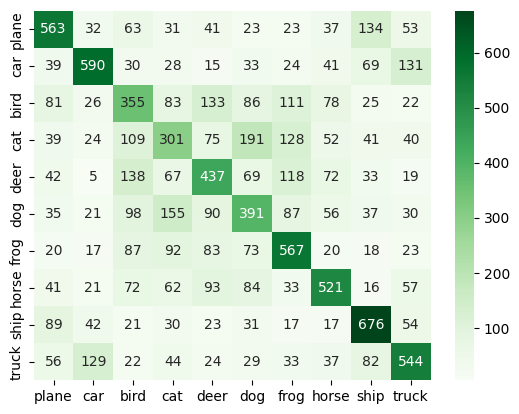

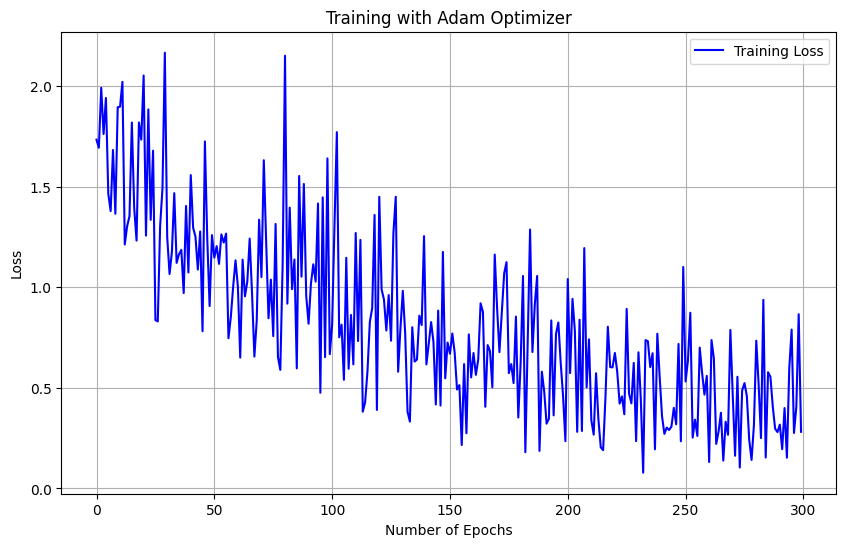

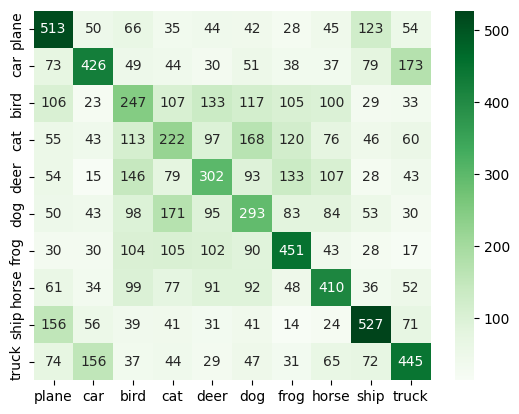

In [20]:
for name, optimizer in optimizers.items():
    model_name = 'model_cifar10_1hl'
    model_path = model_data + model_name + '_' + name.lower() + '.pt'
    res_path = model_data + model_name + '_' + name.lower() + '.pkl'
    exec(model_name + '_loss' + " = 0")
    exec(model_name + '_train_time' + " = 0")

    # Run training loop if model doesn't exist
    if not Path(model_path).is_file():
        print("Training model with " + name + " Optimizer" )
        reset_all_weights(model_cifar10_1hl)
        model_cifar10_1hl_loss, model_cifar10_1hl_train_time = training_loop(
            n_epochs=300, optimizer=optimizer, model=model_cifar10_1hl,
            loss_fn = nn.CrossEntropyLoss(),
            train_loader=trainloader,
            val_loader=testloader
        )
        # Save trained model and results!
        torch.save(model_cifar10_1hl.state_dict(), model_path)
        with open(res_path, 'wb') as f:
            pickle.dump([model_cifar10_1hl_loss, model_cifar10_1hl_train_time], f)
    else: # load model and results from files
        print("Loading model trained with " + name + " optimizer" )
        model_cifar10_1hl.load_state_dict(torch.load(model_path, map_location=device))
        with open(res_path, 'rb') as f:
            model_cifar10_1hl_loss, model_cifar10_1hl_train_time = pickle.load(f)

    # Print results
    train_acc, _, _ = check_model(model_cifar10_1hl, trainloader)
    val_acc, y_pred, y_test = check_model(model_cifar10_1hl, testloader)
    print(f"Training Accuracy: {train_acc}, ",
        f"Validation Accuracy: {val_acc}")
    print(f"Training time: {model_cifar10_1hl_train_time} sec")
    label = "Training with " + name + " Optimizer"
    print(classification_report(y_test, y_pred))
    plot_loss(model_cifar10_1hl_loss, title=label, epoch_step=1)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Greens", fmt='g',
                xticklabels=classes, yticklabels=classes)

### 2b. FC NN CIFAR-10 with 3 Hidden Layers

In [21]:
model_cifar10_3hl = nn.Sequential(
    nn.Linear(3072, 512), # 32 x 32 x 3 = 3072
    nn.Tanh(),
    nn.Linear(512, 256),
    nn.Tanh(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 10)
)
model_cifar10_3hl.to(device) # send to GPU
optimizers = get_optimizers(model_cifar10_3hl)

# Inspect model parameters
numel_list = [p.numel()
              for p in model_cifar10_3hl.parameters()
              if p.requires_grad == True]
print("Model parameters: " + str(numel_list))
print("Total parameters: " + str(sum(numel_list)))

Model parameters: [1572864, 512, 131072, 256, 32768, 128, 1280, 10]
Total parameters: 1738890


Loading model trained with SGD optimizer
Checking model...
Checking model...
Training Accuracy: 0.99916,  Validation Accuracy: 0.433
Training time: 46627.774638175964 sec
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      1000
           1       0.56      0.49      0.52      1000
           2       0.31      0.33      0.32      1000
           3       0.28      0.29      0.29      1000
           4       0.37      0.38      0.37      1000
           5       0.34      0.35      0.34      1000
           6       0.45      0.47      0.46      1000
           7       0.50      0.46      0.48      1000
           8       0.56      0.57      0.57      1000
           9       0.48      0.50      0.49      1000

    accuracy                           0.43     10000
   macro avg       0.44      0.43      0.43     10000
weighted avg       0.44      0.43      0.43     10000



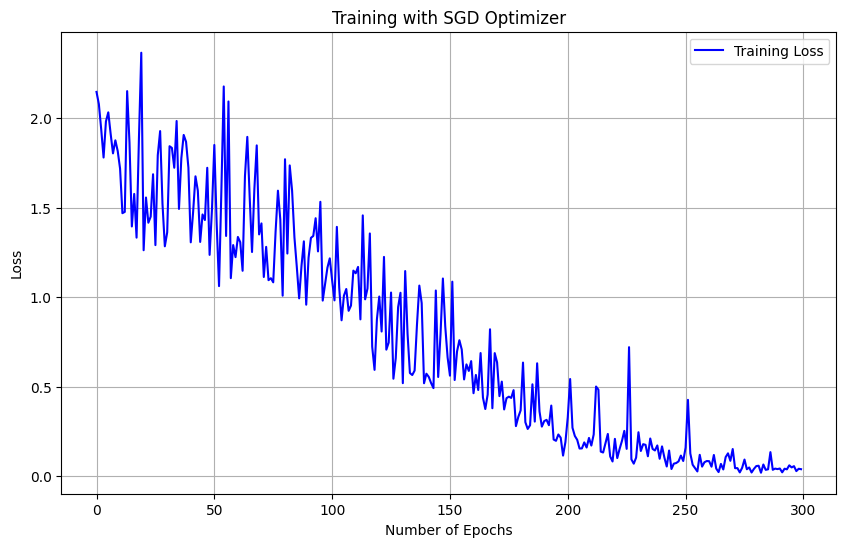

Loading model trained with Adam optimizer
Checking model...
Checking model...
Training Accuracy: 0.73382,  Validation Accuracy: 0.4474
Training time: 78449.14477491379 sec
              precision    recall  f1-score   support

           0       0.53      0.52      0.52      1000
           1       0.54      0.52      0.53      1000
           2       0.36      0.33      0.35      1000
           3       0.29      0.33      0.31      1000
           4       0.36      0.38      0.37      1000
           5       0.35      0.33      0.34      1000
           6       0.50      0.47      0.48      1000
           7       0.52      0.49      0.51      1000
           8       0.57      0.61      0.59      1000
           9       0.48      0.49      0.48      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000
weighted avg       0.45      0.45      0.45     10000



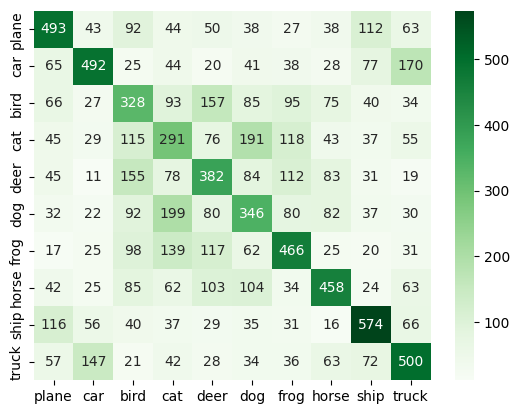

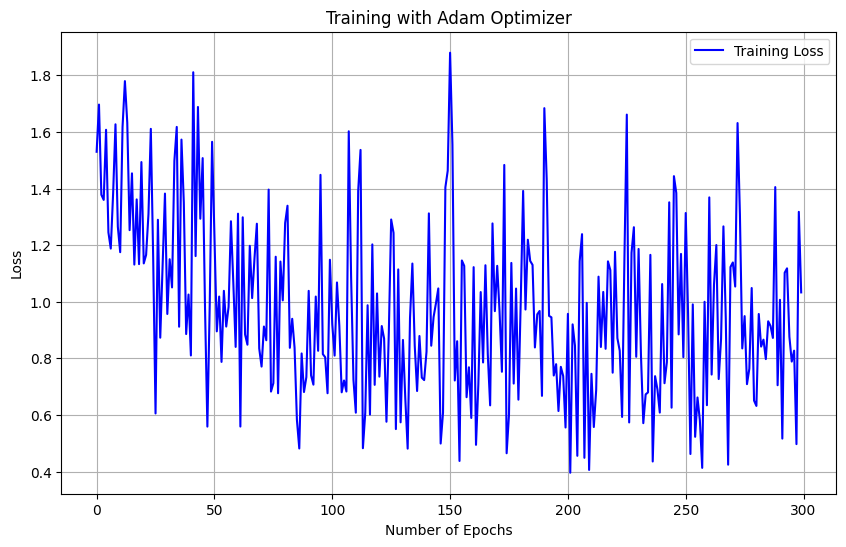

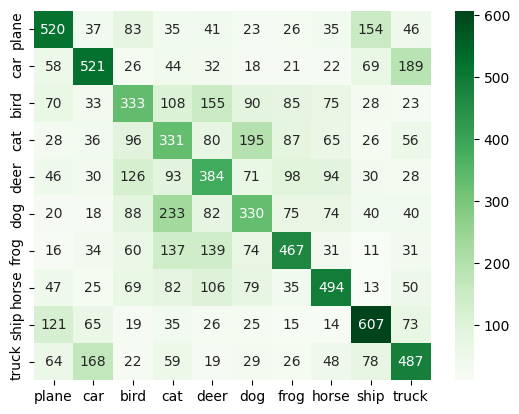

In [22]:
for name, optimizer in optimizers.items():
    model_name = 'model_cifar10_3hl'
    model_path = model_data + model_name + '_' + name.lower() + '.pt'
    res_path = model_data + model_name + '_' + name.lower() + '.pkl'
    exec(model_name + '_loss' + " = 0")
    exec(model_name + '_train_time' + " = 0")

    # Run training loop if model doesn't exist
    if not Path(model_path).is_file():
        print("Training model with " + name + " Optimizer" )
        reset_all_weights(model_cifar10_3hl)
        model_cifar10_3hl_loss, model_cifar10_3hl_train_time = training_loop(
            n_epochs=300, optimizer=optimizer, model=model_cifar10_3hl,
            loss_fn = nn.CrossEntropyLoss(),
            train_loader=trainloader,
            val_loader=testloader
        )
        # Save trained model and results!
        torch.save(model_cifar10_3hl.state_dict(), model_path)
        with open(res_path, 'wb') as f:
            pickle.dump([model_cifar10_3hl_loss, model_cifar10_3hl_train_time], f)
    else: # load model and results from files
        print("Loading model trained with " + name + " optimizer" )
        model_cifar10_3hl.load_state_dict(torch.load(model_path, map_location=device))
        with open(res_path, 'rb') as f:
            model_cifar10_3hl_loss, model_cifar10_3hl_train_time = pickle.load(f)

    # Print results
    train_acc, _, _ = check_model(model_cifar10_3hl, trainloader)
    val_acc, y_pred, y_test = check_model(model_cifar10_3hl, testloader)
    print(f"Training Accuracy: {train_acc}, ",
        f"Validation Accuracy: {val_acc}")
    print(f"Training time: {model_cifar10_3hl_train_time} sec")
    label = "Training with " + name + " Optimizer"
    print(classification_report(y_test, y_pred))
    plot_loss(model_cifar10_3hl_loss, title=label, epoch_step=1)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Greens", fmt='g',
                xticklabels=classes, yticklabels=classes)
